# Using Binomial Trees


## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

You do not have the functions to run this notebook, but it is meant to illustrate the use of binomial trees.

***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *
sys.path.insert(0, '../dev')
from bintree import *

***

In [6]:
DATE = '2025-01-31'
FILEIN = f'../data/fiderivs_data_{DATE}.xlsx'
#CMPNDQUOTES = 4
CMPND_RATETREE = None

CMPND_RATECURVES = 4
freqcurve = 4
dt = 1/freqcurve

sheet_curves = 'rate curves'
sheet_tree = 'rate tree'
sheet_volskew = 'bloomberg vcub'
sheet_sabrparams = 'sabr params'

In [7]:
ratetree = pd.read_excel(FILEIN, sheet_name=sheet_tree).set_index('state')
ratetree.columns.name = 'time'
refratetree = freqcurve * (np.exp(ratetree / freqcurve)-1)
label_ratetree = f'Tree: Rates (compounding={freqcurve})'

In [8]:
curves = pd.read_excel(FILEIN, sheet_name=sheet_curves).set_index('tenor')
volskew = pd.read_excel(FILEIN, sheet_name=sheet_volskew)

In [9]:
display_bintree_valuation(ratetree,refratetree,charttype='df',title='Rates (compounding={freqcurve})',fmt='{:.1%}')#,figsize=(7,4))

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75
state,,,,,,,,,,,,,,,,,,,,
0,4.2%,4.3%,4.5%,4.8%,5.1%,6.5%,7.7%,9.2%,10.3%,11.9%,13.7%,15.6%,17.3%,19.7%,23.3%,26.7%,29.2%,31.8%,36.3%,42.4%
1,,3.9%,4.0%,4.2%,4.4%,5.2%,6.0%,7.1%,7.9%,9.2%,10.5%,12.0%,13.3%,15.1%,17.8%,20.4%,22.3%,24.5%,27.9%,32.5%
2,,,3.6%,3.7%,3.8%,4.2%,4.7%,5.5%,6.1%,7.0%,8.1%,9.2%,10.2%,11.6%,13.6%,15.6%,17.1%,18.8%,21.5%,25.0%
3,,,,3.3%,3.2%,3.4%,3.7%,4.2%,4.7%,5.4%,6.2%,7.1%,7.8%,8.9%,10.4%,11.9%,13.1%,14.5%,16.6%,19.2%
4,,,,,2.8%,2.7%,2.9%,3.3%,3.6%,4.1%,4.8%,5.5%,6.0%,6.8%,8.0%,9.2%,10.1%,11.2%,12.8%,14.8%
5,,,,,,2.2%,2.3%,2.5%,2.8%,3.2%,3.7%,4.2%,4.6%,5.2%,6.1%,7.0%,7.8%,8.6%,9.9%,11.5%
6,,,,,,,1.8%,2.0%,2.1%,2.4%,2.8%,3.2%,3.6%,4.0%,4.7%,5.4%,6.0%,6.7%,7.7%,8.9%
7,,,,,,,,1.5%,1.6%,1.9%,2.2%,2.5%,2.8%,3.1%,3.6%,4.1%,4.6%,5.2%,6.0%,6.8%
8,,,,,,,,,1.3%,1.4%,1.7%,1.9%,2.1%,2.4%,2.8%,3.2%,3.5%,4.0%,4.6%,5.3%


***

## Pricing a Floor

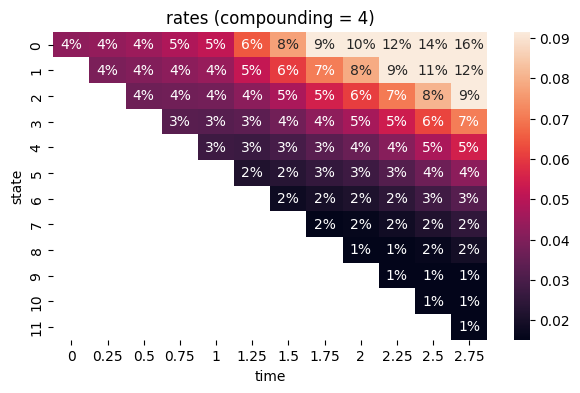

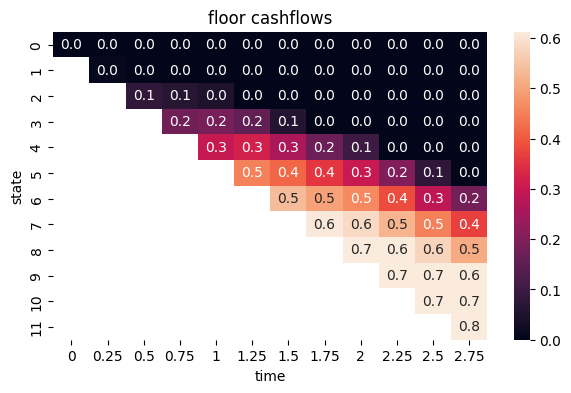

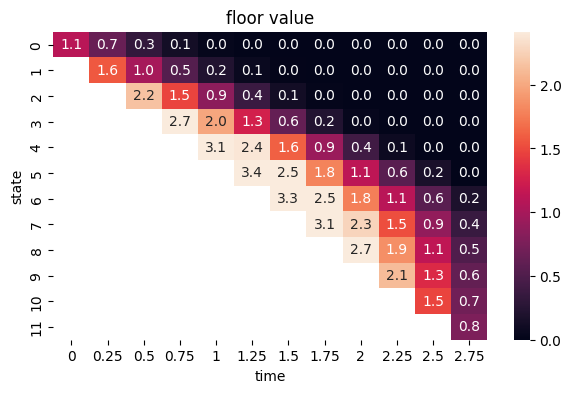

,model value
binomial,1.10
black,1.13


In [11]:
SECURITY = 'floor'
isPayer = False
T=3
freq = 4

CHARTTYPE = 'heatmap'

output = bintrees(SECURITY,ratetree,curves,T=T,cffreq=freq,isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE)

fmt_rtree = display_bintree_valuation(ratetree,output['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%')
fmt_cftree = display_bintree_valuation(ratetree,output['tree cf'],title=f'{SECURITY} cashflows',charttype=CHARTTYPE)
fmt_valtree = display_bintree_valuation(ratetree,output['tree value'],title=f'{SECURITY} value',charttype=CHARTTYPE)

display(fmt_rtree)
display(fmt_cftree)
display(fmt_valtree)
display(output['table'].style.format('{:.2f}'))

***

# Swaps

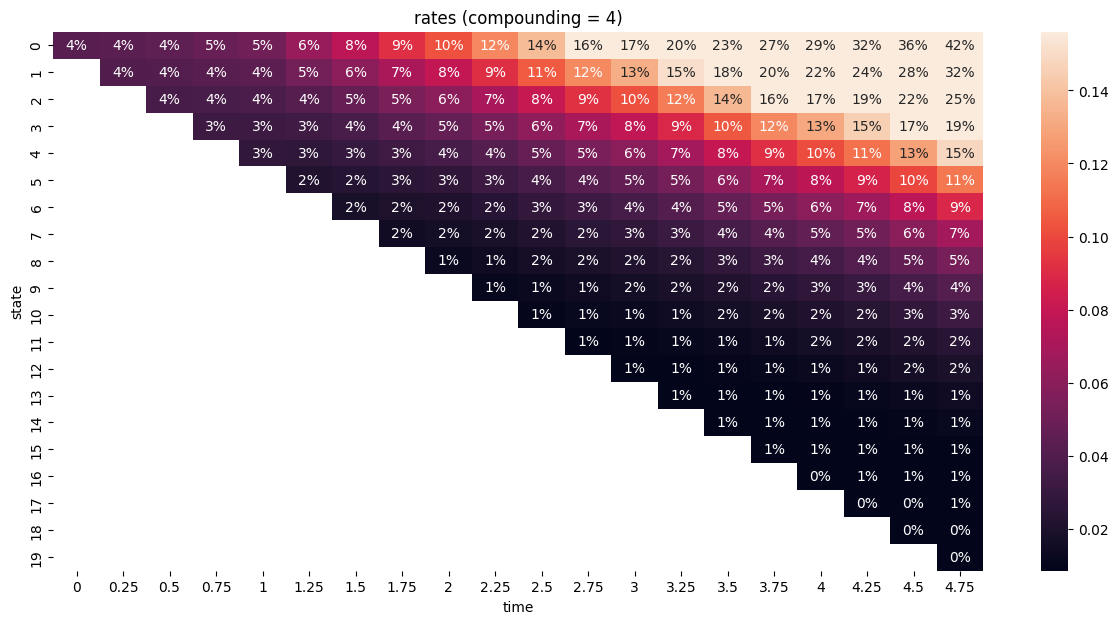

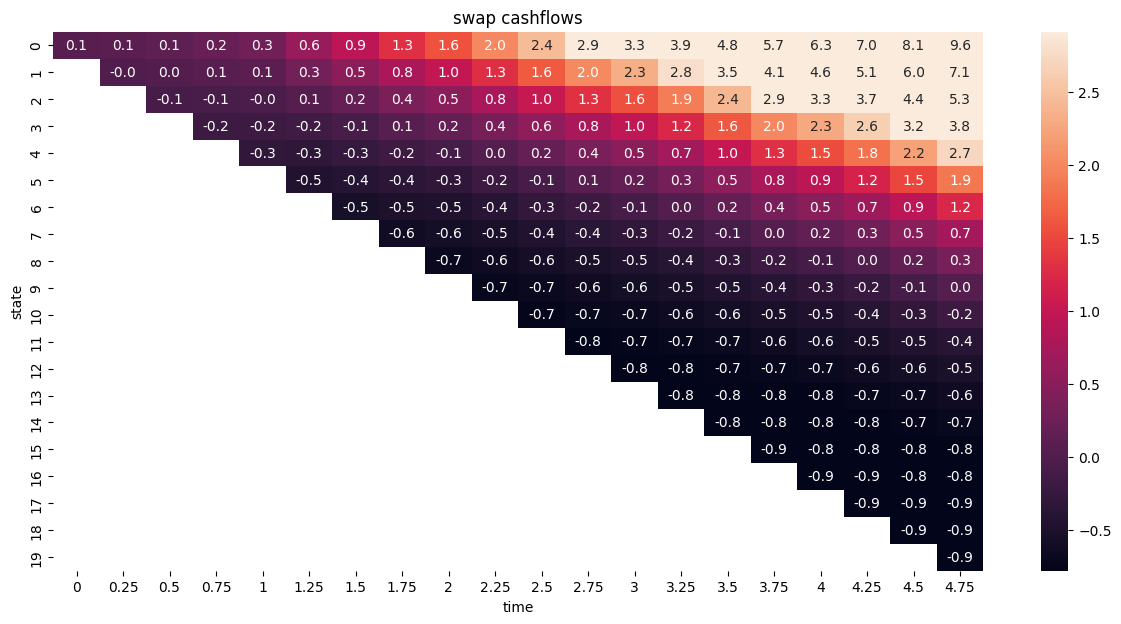

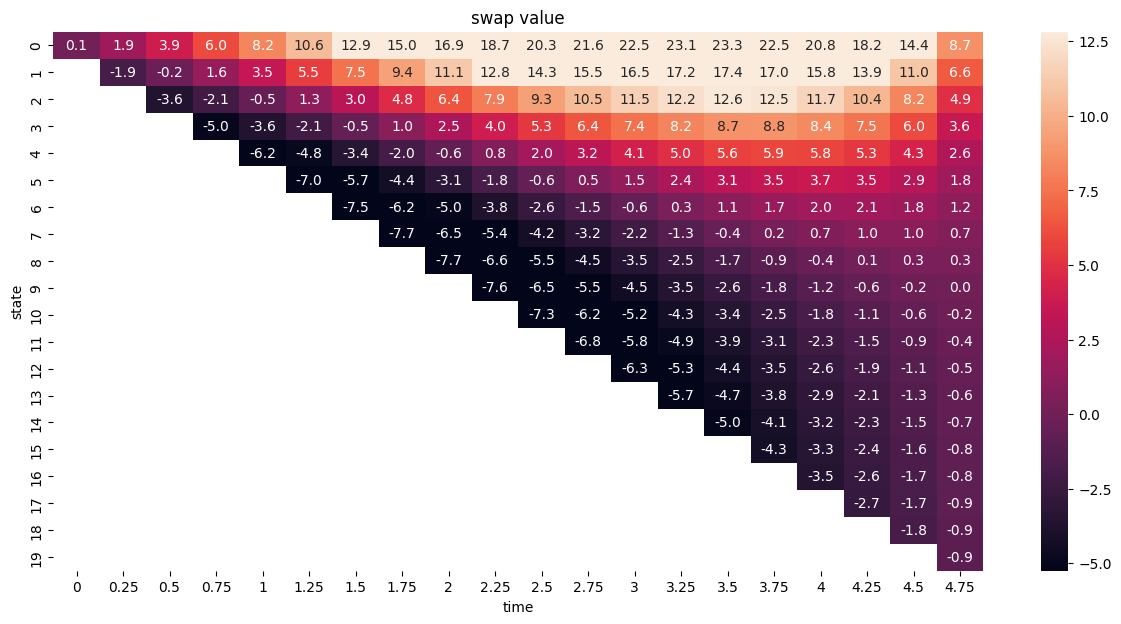

,model value
binomial,0.05
analytic,0.05


In [12]:
SECURITY = 'swap'

Tunder = 3
Topt = 2
T = Tunder + Topt
freq = 4
isPayer = True

output = bintrees(SECURITY,ratetree,curves,T=T,Topt=Topt,cffreq=freq,isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE)
valtrees=dict()
valtrees['swap'] = output['tree value']

fmt_rtree = display_bintree_valuation(ratetree,output['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%',figsize=(15,7))
fmt_cftree = display_bintree_valuation(ratetree,output['tree cf'],title=f'{SECURITY} cashflows',charttype=CHARTTYPE,figsize=(15,7))
fmt_valtree = display_bintree_valuation(ratetree,output['tree value'],title=f'{SECURITY} value',charttype=CHARTTYPE,figsize=(15,7))

display(fmt_rtree)
display(fmt_cftree)
display(fmt_valtree)
display(output['table'].style.format('{:.2f}'))

#### Confirm swap valuation

The swap at the forward swap rate has nonzero value.

Confirm whether the swat at the spot swap rate has zero value as it should.

In [13]:
strike = curves.loc[T,'swap rates']
output = bintrees(SECURITY,ratetree,curves,T=T,Topt=Topt,strike = strike, cffreq=freq,isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE)
display(output['table'].style.format('{:.4f}'))

,model value
binomial,-0.0000
analytic,0.0000


***

# Swaption

In [14]:
SECURITY = 'swaption'
STYLE = 'european'

#### Load Implied Vol from market quote

In [15]:
swapvol_data = pd.read_excel(FILEIN, sheet_name='bloomberg vcub').set_index('instrument')
swapvol = swapvol_data.loc['swaption',0]/100

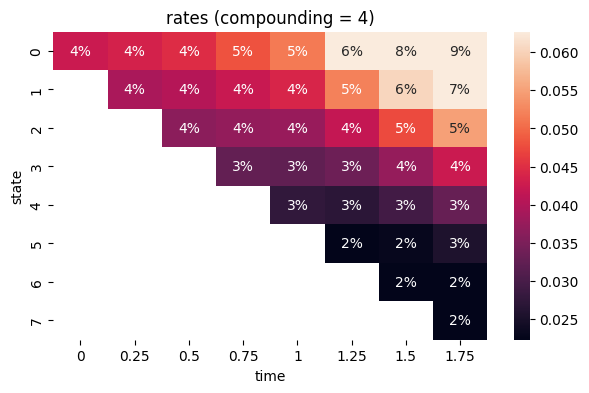

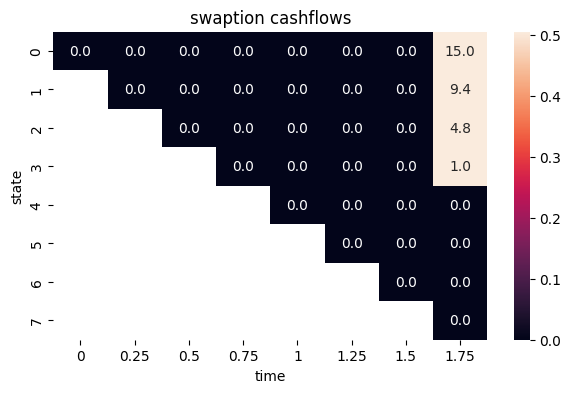

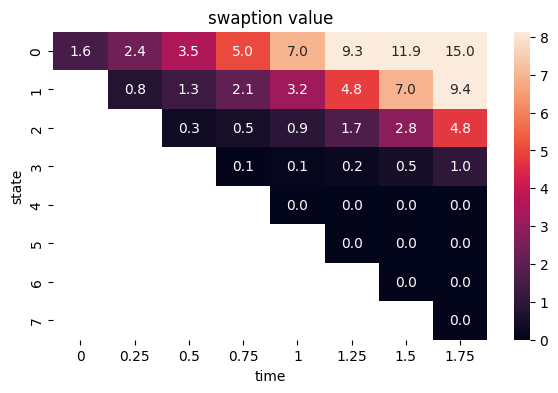

,swaption value
binomial,1.56
black,1.50


In [16]:
output = bintrees(SECURITY,ratetree,curves,T=T,Topt=Topt,undertree=valtrees['swap'],style=STYLE,ivol=swapvol,cffreq=freq,isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE)
valtrees['swaption european'] = output['tree value']

fmt_rtree = display_bintree_valuation(ratetree,output['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%')
fmt_cftree = display_bintree_valuation(ratetree,output['tree cf'],title=f'{SECURITY} cashflows',charttype=CHARTTYPE)
fmt_valtree = display_bintree_valuation(ratetree,output['tree value'],title=f'{SECURITY} value',charttype=CHARTTYPE)

display(fmt_rtree)
display(fmt_cftree)
display(fmt_valtree)
display(output['table'].style.format('{:.2f}'))

### American Exercise

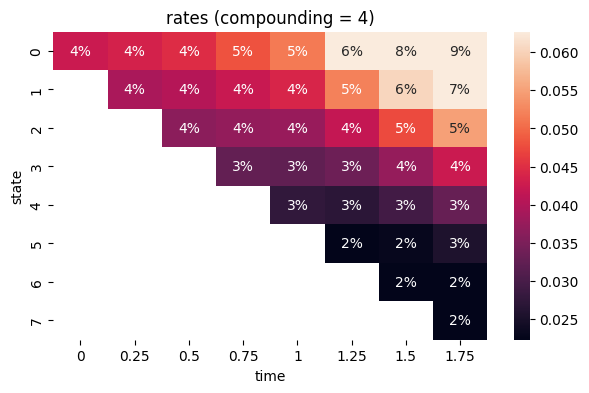

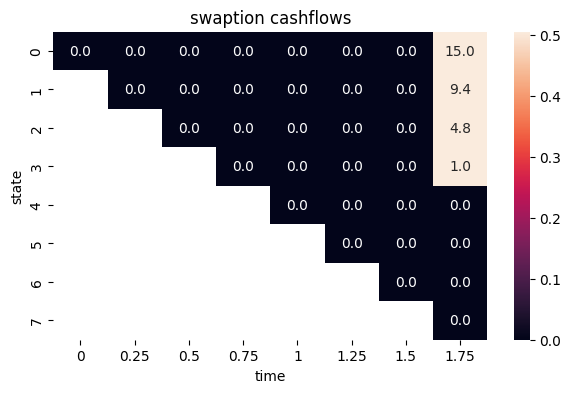

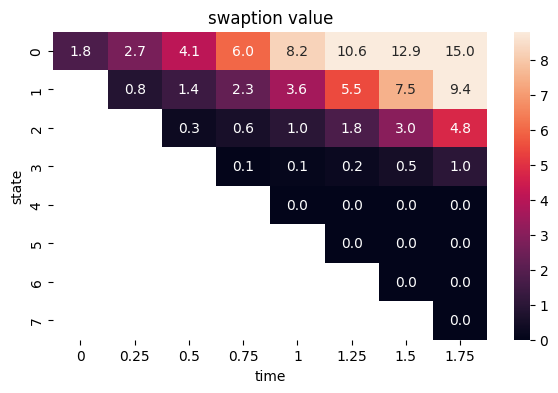

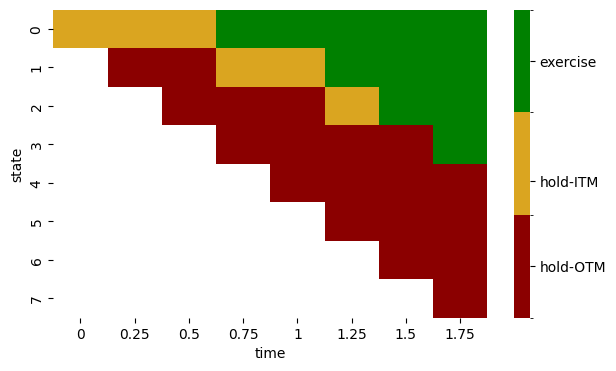

,swaption value
binomial,1.76
black,1.50


In [17]:
STYLE='american'
output = bintrees(SECURITY,ratetree,curves,T=T,Topt=Topt,undertree=valtrees['swap'],style=STYLE,ivol=swapvol,cffreq=freq,isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE)
valtrees['swaption american'] = output['tree value']

fmt_rtree = display_bintree_valuation(ratetree,output['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%')
fmt_cftree = display_bintree_valuation(ratetree,output['tree cf'],title=f'{SECURITY} cashflows',charttype=CHARTTYPE)
fmt_valtree = display_bintree_valuation(ratetree,output['tree value'],title=f'{SECURITY} value',charttype=CHARTTYPE)

display(fmt_rtree)
display(fmt_cftree)
display(fmt_valtree)
display(output['tree exercise'])
display(output['table'].style.format('{:.2f}'))

***

# Bond

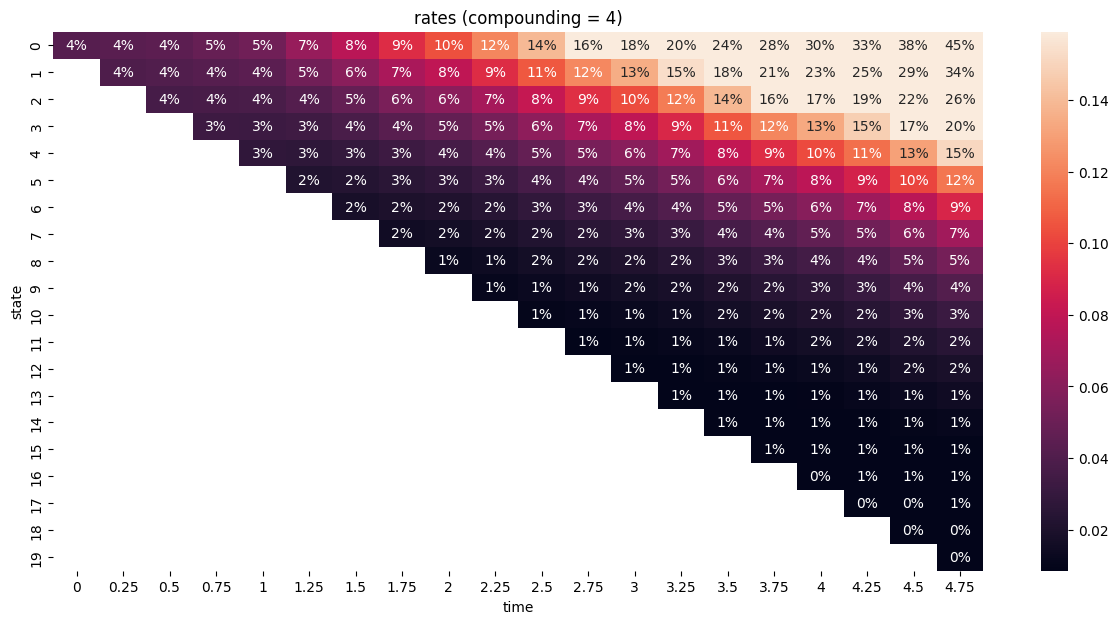

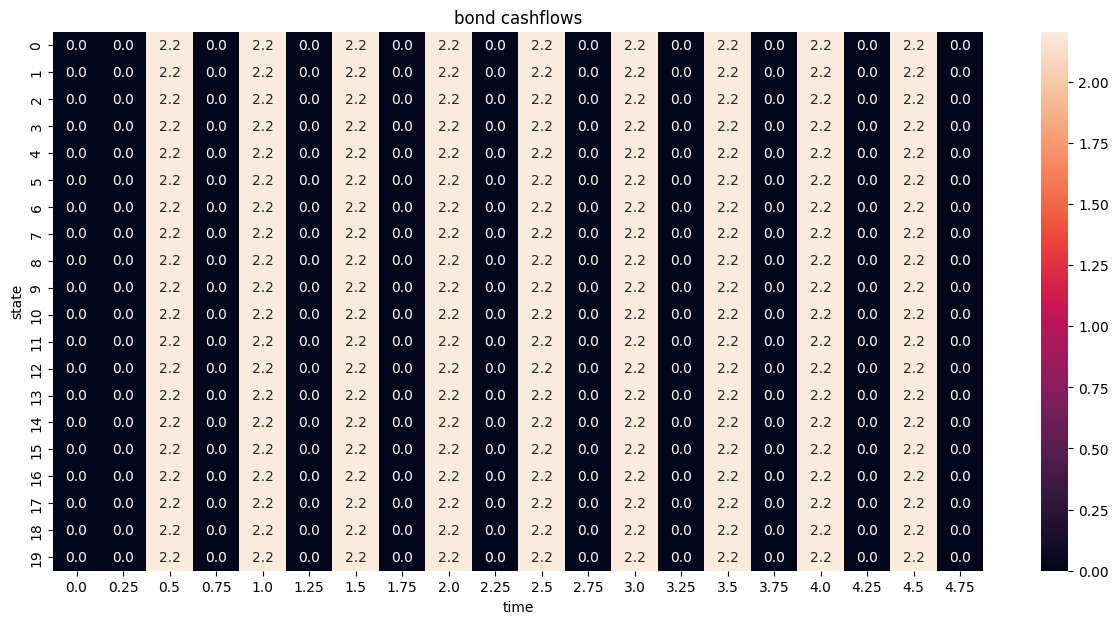

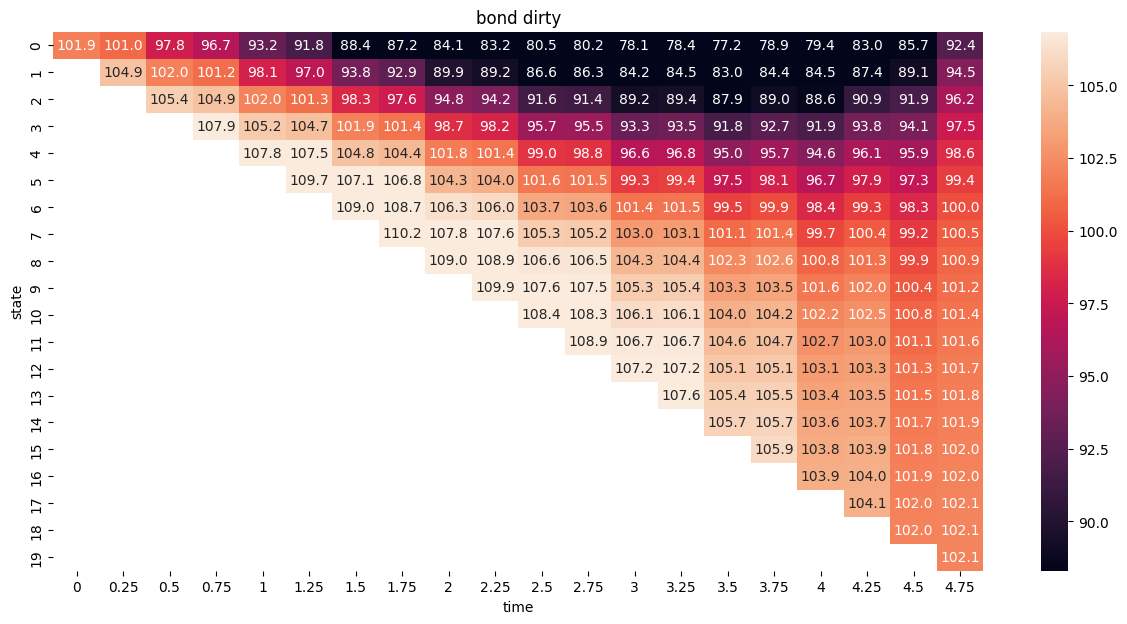

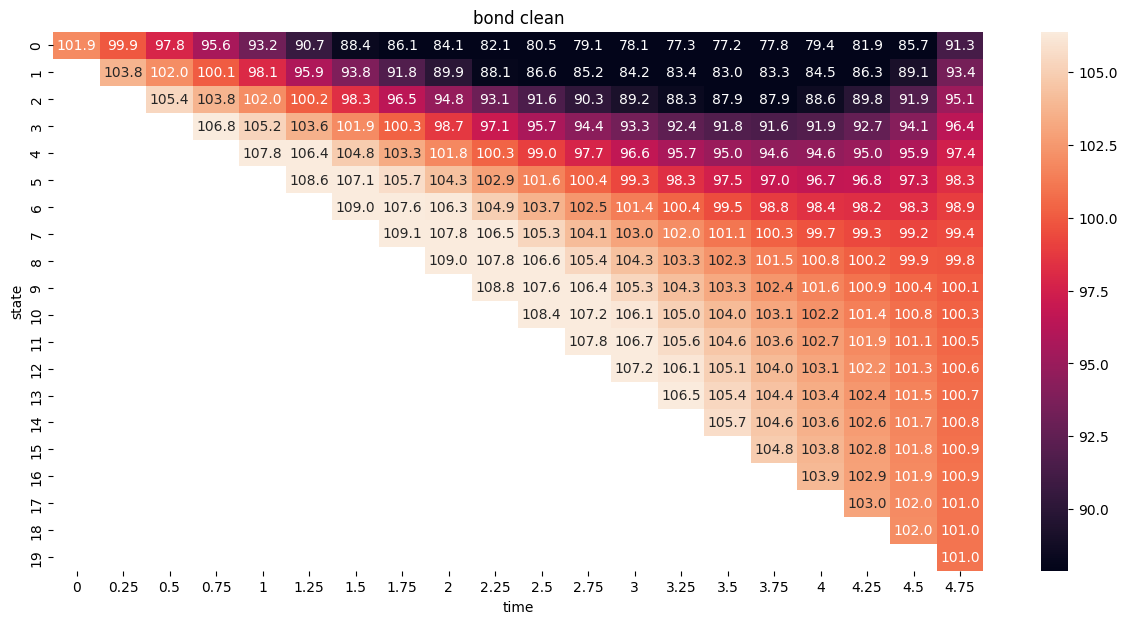

,value
dirty,101.87
clean,101.87


In [18]:
T = 5
CPNFREQ = 2

CPN = .0441

SECURITY = 'bond'

output = bintrees(SECURITY,ratetree,curves,T=T,cpnrate=CPN,cffreq=CPNFREQ,cmpnd_ratetree=CMPND_RATETREE)
valtrees['clean bond'] = output['tree clean']

fmt_rtree = display_bintree_valuation(ratetree,output['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%',figsize=(15,7))
fmt_cftree = display_bintree_valuation(ratetree,output['tree cf'],title=f'{SECURITY} cashflows',charttype=CHARTTYPE,figsize=(15,7))
fmt_dirty = display_bintree_valuation(ratetree,output['tree dirty'],title=f'{SECURITY} dirty',charttype=CHARTTYPE,figsize=(15,7))
fmt_clean = display_bintree_valuation(ratetree,output['tree clean'],title=f'{SECURITY} clean',charttype=CHARTTYPE,figsize=(15,7))

display(fmt_rtree)
display(fmt_cftree)
display(fmt_dirty)
display(fmt_clean)
display(output['table'].style.format('{:.2f}'))

***

# Callable Bond

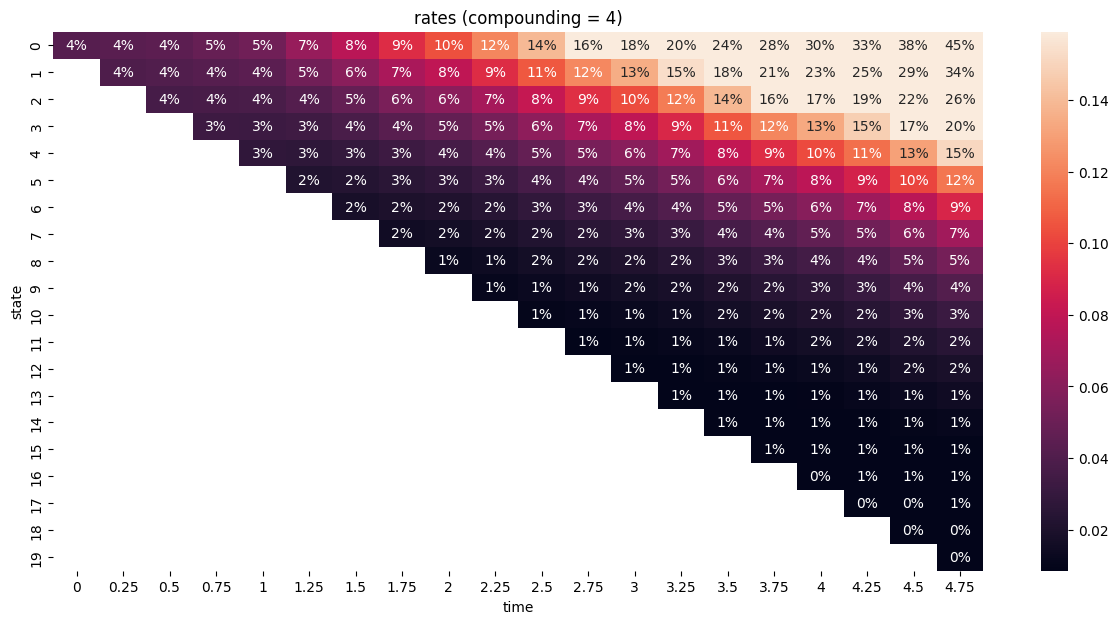

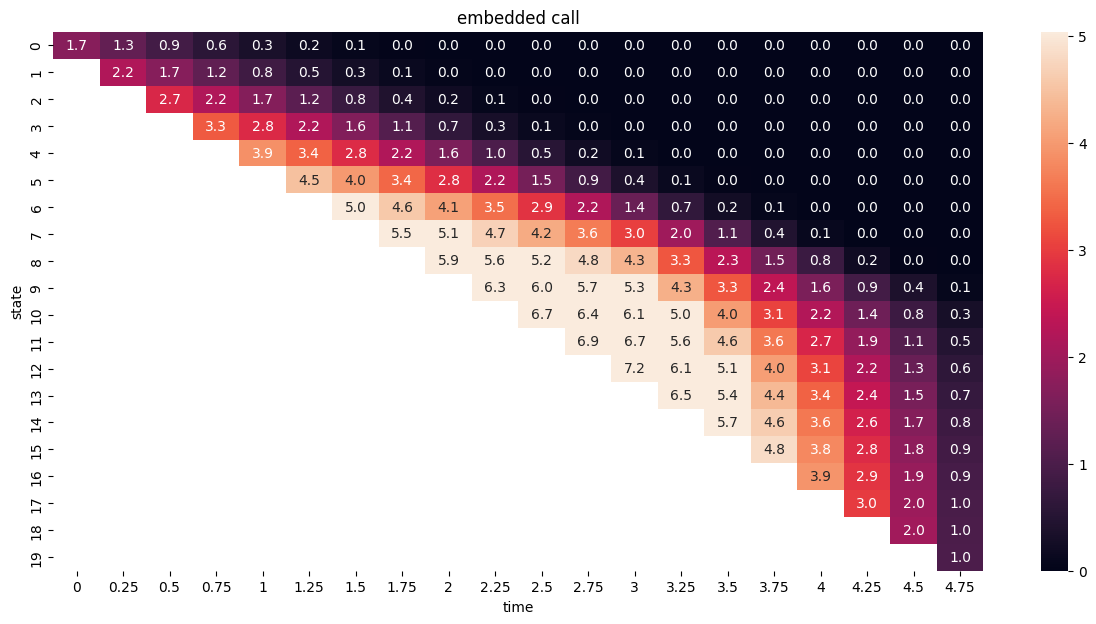

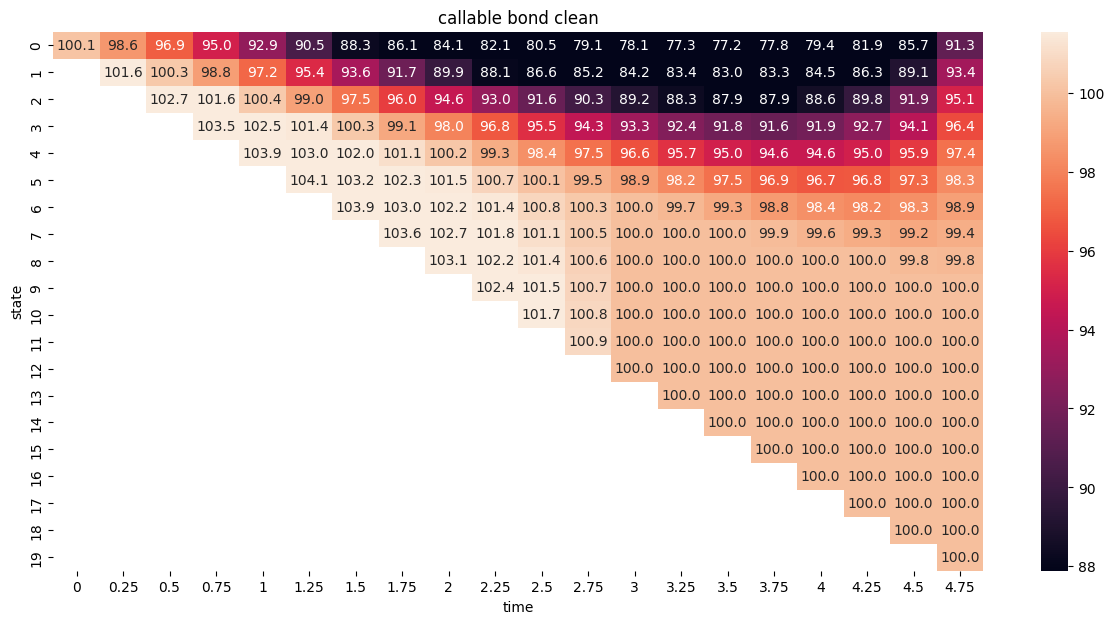

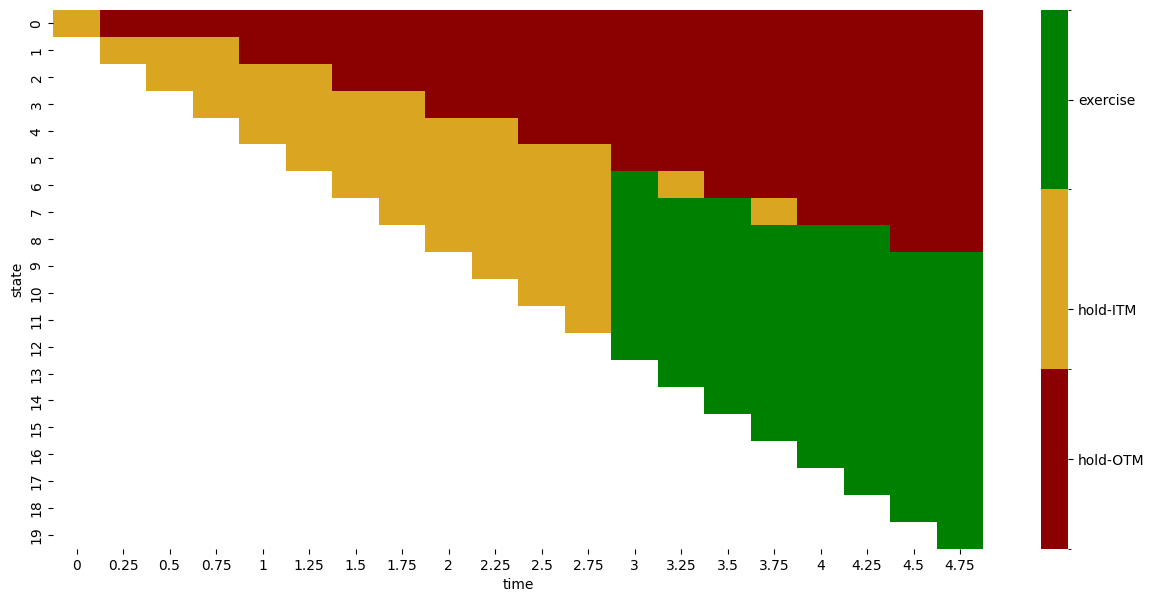

,embedded call,callable (clean)
non-callable,0.00,101.87
european,1.65,100.22
bermudan,1.72,100.15
american,2.96,98.91


,binomial,black
vanilla bond,101.87,101.87
call,1.65,1.62
callable bond,100.22,100.25


In [19]:
SECURITY = 'callable bond'
STYLES = ['european','bermudan','american']
DISP_STYLE = 'bermudan'

Topt = 3
STRIKE = 100
isPayer = True

tabdata = pd.DataFrame(dtype=float,index=STYLES,columns=['embedded call','callable (clean)']).T
tabdata.insert(0,'non-callable',np.array([0,valtrees['clean bond'].iloc[0,0]]))
tabdata = tabdata.T

#tabdata_baseline = pd.DataFrame(columns=['vanilla'],data=[0,valtrees['clean bond'].iloc[0,0]],index = tabdata.columns)
#tabdata = pd.concat([tabdata,tabdata_baseline],axis=0)

output = dict()
for style in STYLES:
    output[style] = bintrees(SECURITY,ratetree,curves,T=T,Topt=Topt,undertree = valtrees['clean bond'],strike=STRIKE, cpnrate=CPN, style=style, cffreq=CPNFREQ, isPayer=isPayer,cmpnd_ratetree=CMPND_RATETREE,cmpnd_ratecurve=CMPND_RATECURVES, quote_date=DATE)
    tabdata.loc[style] = [output[style]['tree call'].iloc[0,0], output[style]['tree clean'].iloc[0,0]]



fmt_rtree = display_bintree_valuation(ratetree,output[DISP_STYLE]['tree refrates'],title=f'rates (compounding = {freq})',charttype=CHARTTYPE,fmt='.0%',figsize=(15,7))
fmt_call = display_bintree_valuation(ratetree,output[DISP_STYLE]['tree call'],title=f'embedded call',charttype=CHARTTYPE,figsize=(15,7))
fmt_clean = display_bintree_valuation(ratetree,output[DISP_STYLE]['tree clean'],title=f'{SECURITY} clean',charttype=CHARTTYPE,figsize=(15,7))

display(fmt_rtree)
display(fmt_call)
display(fmt_clean)
display(output[DISP_STYLE]['tree exercise'])
display(tabdata.style.format('{:.2f}'))
display(output['european']['table'].style.format('{:.2f}'))

***